In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import seaborn as sns
import sys
import math
import random

# Prevent Python from generating .pyc files (compiled bytecode files)
sys.dont_write_bytecode = True

# Import necessary modules and configuration settings
from prompts import *
from model import *
from utils import *

INFO 12-18 15:10:40 [__init__.py:243] Automatically detected platform cuda.


In [2]:
generated = pd.read_csv("/home/pallaoro/syngen/data/output/merged100Generated.csv").reset_index(drop=True)
gold = pd.read_csv(outputFileGold).reset_index(drop=True)

In [3]:
labels = list(set(gold[gold[classColumn] == labelClass][contentColumn]))
goldExactSynonymData = gold[gold[classColumn] == exactSynonymClass]
goldData = goldExactSynonymData[~goldExactSynonymData[contentColumn].isin(labels)]

In [4]:
# Map system to 1 / 0
systems = list(set(generated[systemColumn].tolist()))
systemsName = []
for system in systems:
    systemsName.append(system[str(system).index("/") + 1:])

generated[systemColumn] = generated[systemColumn].fillna("")
generated.loc[generated[systemColumn] == "", systemColumn] = ""

In [5]:
colors = plt.cm.tab10(range(len(systems) + 1))

roundCount = int(max(generated[roundColumn].tolist()))

xRoundTicks = 5
xRound = np.arange(1, roundCount + 1)
xRoundTickList = [1] + list(np.arange(xRoundTicks, roundCount + 1, xRoundTicks))

In [6]:
def getSystemData(data : pd.DataFrame, system : str) -> list:
    return list(set(data[data[systemColumn] == system].tolist()))

In [7]:
def getSystemRoundData(data : pd.DataFrame, system : str, round : int) -> list:
    # Reduce Data to System data
    systemData = data[data[systemColumn] == system]
    # Reduce Data to Round data
    systemRoundData = systemData[systemData[roundColumn] == round]
    
    return list(set(systemRoundData[contentColumn].tolist()))

In [8]:
def getCumulativeSystemRoundData(data : pd.DataFrame, system : str, round : int) -> list:
    # Reduce Data to System data
    systemData = data[data[systemColumn] == system]
    # Reduce Data to Round and pre-Round data
    systemRoundData = systemData[systemData[roundColumn] <= round]
    
    return list(set(systemRoundData[contentColumn].tolist()))

In [9]:
def getSystemRoundHPOData(data : pd.DataFrame, system : str, round : int, hpoID : str) -> list:
    # Reduce Data to System data
    systemData = data[data[systemColumn] == system]
    # Reduce Data to Round data
    systemRoundData = systemData[systemData[roundColumn] == round]
    # Reduce Data to HPO ID data
    systemRoundHPOData = systemRoundData[systemRoundData[hpoidColumn] == hpoID]
    
    return list(set(systemRoundHPOData[contentColumn].tolist()))

In [10]:
def getCumulativeSystemRoundHPOData(data : pd.DataFrame, system : str, round : int, hpoID : str) -> list:
    # Reduce Data to System data
    systemData = data[data[systemColumn] == system]
    # Reduce Data to Round data
    systemRoundData = systemData[systemData[roundColumn] <= round]
    # Reduce Data to HPO ID data
    systemRoundHPOData = systemRoundData[systemRoundData[hpoidColumn] == hpoID]
    
    return list(set(systemRoundHPOData[contentColumn].tolist()))

In [11]:
def getHighestAppearance(data : pd.DataFrame, system : str) -> int:
    element = max(set(data.loc[data[systemColumn] == system, contentColumn].tolist()), key=data.loc[data[systemColumn] == system, contentColumn].tolist().count)
    return len(generated[(generated[contentColumn] == element) & (generated[systemColumn] == system)].index)

In [12]:
def getAppearanceSystemHPOData(data : pd.DataFrame, system : str, hpoID : str, count : int) -> list:
    ret = []
    
    # Reduce Data to System data
    systemData = data[data[systemColumn] == system]
    # Reduce Data to HPO ID data
    systemHPOData = systemData[systemData[hpoidColumn] == hpoID]

    gen = systemHPOData[contentColumn].tolist()
    for g in list(set(gen)):
        c = gen.count(g)
        if c >= count:
            ret.append(g)

    return ret

In [13]:
def getNewSynonymsSystemRound(data : pd.DataFrame, system : str, round : int) -> list:
    ret = []

    systemData = data[data[systemColumn] == system]
    # Reduce Data to Round data

    if round == 0:
        ret = list(set(systemData[systemData[roundColumn] == 0][contentColumn]))
    else:
        systemRoundData = systemData[systemData[roundColumn] <= round][contentColumn].tolist()
        systemPreviousRoundData = systemData[systemData[roundColumn] <= round - 1][contentColumn].tolist()

        ret = list(set(systemRoundData).difference(set(systemPreviousRoundData)))

    return ret

In [ ]:
def splitEqualParts(start : float, end : float, parts : int, cut : int = 2) -> list:
    ret = list(np.linspace(start, end, parts))
    for index in range(0, len(ret)):
        ret[index] = math.trunc(ret[index] * math.pow(10, cut)) / math.pow(10, cut)
    return ret

In [15]:
def splitEqualPartsLabels(start : float, end : float, parts : int, cut : int = 2, prefix : str = "", postfix : str = "", multiplier : int = 1) -> list:
    ret = splitEqualParts(start, end, parts, cut)

    for index in range(0, len(ret)):

        value = str(ret[index] * multiplier)

        if "." in value:
            value = value.split(".")
            
            if cut > 0:
                if len(value[1]) > cut:
                    tmp = value[1]
                    value[1] = str(round(float(tmp[0:cut])))
            else:
                value[1] = "0"

            if not value[1] == "0":
                value = ".".join(value)
            else:
                value = value[0]

        ret[index] = prefix + str(value) + postfix

    return ret

In [16]:
def getPercentage(interval: float = 0.1, additional: int = 1) -> list:
    ret = []
    numbers = list(np.arange(0, 1.01, interval))

    for number in numbers:
        ret.append(str(math.floor(100 * number)) + "%")

    for _ in range(0, additional):
        ret.append("")

    return ret

In [17]:
result = {}
maxVal = 0

for system in systems:
    count = [0] * roundCount

    for r in range(0, roundCount):
        count[r] = len(getSystemRoundData(generated, system, r + 1))
        if count[r] > maxVal:
            maxVal = count[r]

    result[system] = {
        "counts" : count 
    }

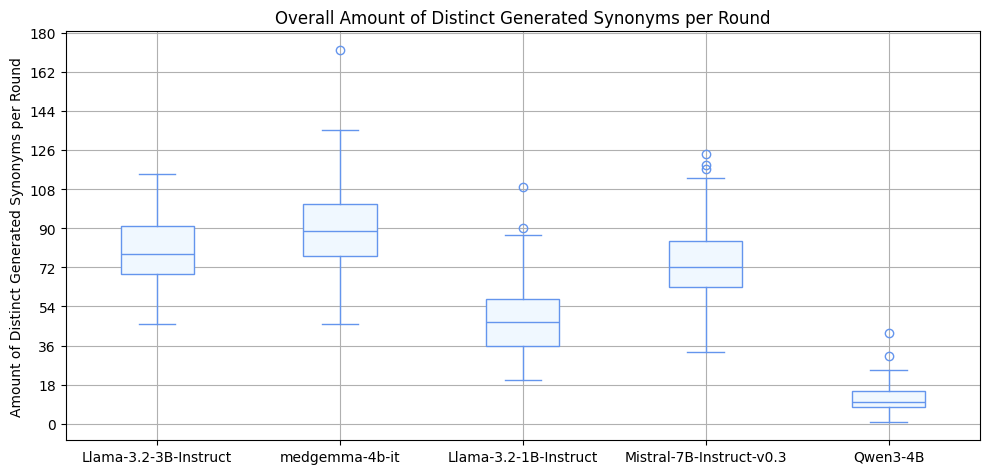

In [18]:
yticks = 10

# Extract data for plotting
data = [result[system]["counts"] for system in systems]

# Create the boxplot
plt.figure(figsize=(2 * len(systems), 5))
plt.boxplot(
    data,
    showfliers=True,
    widths=[0.4] * len(systems),
    patch_artist=True,
    boxprops=dict(facecolor="aliceblue", color="cornflowerblue"),
    medianprops=dict(color="cornflowerblue"),
    whiskerprops=dict(color="cornflowerblue"),
    capprops=dict(color="cornflowerblue"),
    flierprops=dict(markeredgecolor="cornflowerblue")
)
plt.title("Overall Amount of Distinct Generated Synonyms per Round")
plt.suptitle("")
plt.xlabel("")
plt.xticks(range(1, len(systems) + 1), labels=systemsName)
plt.ylabel("Amount of Distinct Generated Synonyms per Round")
plt.yticks(range(0, int(maxVal * 1.1) , int(maxVal * 1.1 / yticks)))
plt.tight_layout()
plt.grid(visible=True)
plt.show()

In [19]:
result = {}
maxVal = 0

for system in systems:
    count = [0] * len(testIDs)

    for index, hpoID in enumerate(testIDs):
        count[index] = len(getCumulativeSystemRoundHPOData(generated, system, roundCount + 1, hpoID))
        if count[index] > maxVal:
            maxVal = count[index]

    result[system] = {
        "counts" : count 
    }

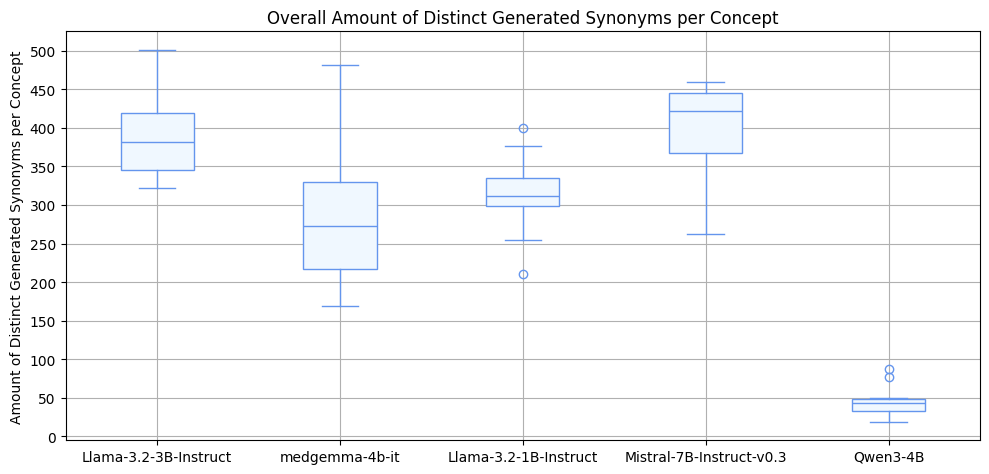

In [20]:
yticks = math.ceil(maxVal / 500)

# Extract data for plotting
data = [result[system]["counts"] for system in systems]

# Create the boxplot
plt.figure(figsize=(2 * len(systems), 5))
plt.boxplot(
    data,
    showfliers=True,
    widths=[0.4] * len(systems),
    patch_artist=True,
    boxprops=dict(facecolor="aliceblue", color="cornflowerblue"),
    medianprops=dict(color="cornflowerblue"),
    whiskerprops=dict(color="cornflowerblue"),
    capprops=dict(color="cornflowerblue"),
    flierprops=dict(markeredgecolor="cornflowerblue")
)
plt.title("Overall Amount of Distinct Generated Synonyms per Concept")
plt.suptitle("")
plt.xlabel("")
plt.xticks(range(1, len(systems) + 1), labels=systemsName)
plt.ylabel("Amount of Distinct Generated Synonyms per Concept")

yticksList = splitEqualParts(0, maxVal + 1, 10, 0)
yticksLabels = splitEqualPartsLabels(0, maxVal + 1, 10, 0)
plt.yticks(
    ticks=yticksList,
    labels=yticksLabels
)

plt.tight_layout()
plt.grid(visible=True)
plt.show()

In [21]:
result = {}
maxVal = 0

for index, system in enumerate(systems):
    counts = [0] * roundCount
    relatives = [0] * roundCount
    
    for r in range(0, roundCount):
        counts[r] = len(getNewSynonymsSystemRound(generated, system, r + 1))
        relatives[r] = counts[r] / len(getSystemRoundData(generated, system, r + 1))

        if counts[r] > maxVal:
            maxVal = counts[r]

    result[system] = {
        "counts" : counts,
        "relatives" : relatives
    }

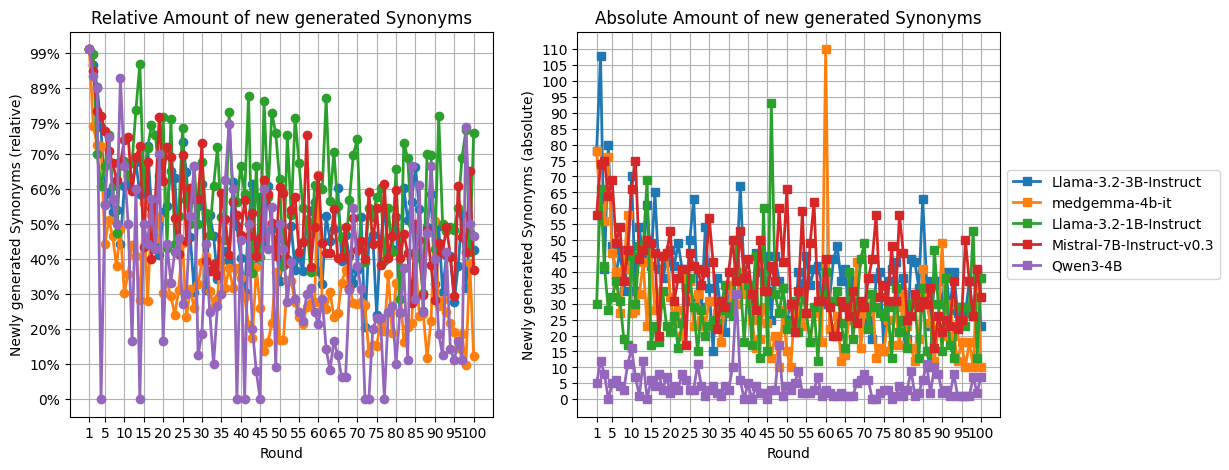

In [22]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))

yticks = math.ceil(maxVal / 5)

for system in result.keys():
    axs[0].plot(xRound, result[system]["relatives"], marker='o', color=colors[systems.index(system)], linewidth=2, label=systemsName[systems.index(system)])
    axs[1].plot(xRound, result[system]["counts"], marker='s', color=colors[systems.index(system)], linewidth=2, label=systemsName[systems.index(system)])

axs[0].set_xlabel("Round")
axs[0].set_ylabel("Newly generated Synonyms (relative)")
axs[0].grid(True)
axs[0].set_yticks(splitEqualParts(0, 1, 10, 2))
axs[0].set_yticklabels(splitEqualPartsLabels(0, 1, 10, 2, "", "%", 100))
axs[0].set_xticks(xRoundTickList)
axs[0].set_title("Relative Amount of new generated Synonyms")

axs[1].set_yticks(splitEqualParts(0, maxVal + 1, yticks, 0)) 
axs[1].set_yticklabels(splitEqualPartsLabels(0, maxVal + 1, yticks, 0))
axs[1].set_ylabel("Newly generated Synonyms (absolute)")
axs[1].set_xticks(xRoundTickList)
axs[1].set_xlabel("Round")
axs[1].grid(True)
axs[1].set_title("Absolute Amount of new generated Synonyms")

# Combine legends from both axes
lines_1, labels_1 = axs[0].get_legend_handles_labels()
lines_2, labels_2 = axs[1].get_legend_handles_labels()
axs[1].legend(lines_1 + lines_2, labels_1 + labels_2)

#plt.title("Newly generated Synonyms per Round")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [23]:
maxprecision = 0
maxrecall = 0

result = {}

for index, system in enumerate(systems):
    coverage  = [0] * roundCount
    precision = [0] * roundCount
    recall    = [0] * roundCount

    for r in range(0, roundCount):
        for hpoID in testIDs:
            ge = set(getCumulativeSystemRoundHPOData(generated, system, r, hpoID))
            go = set(goldData.loc[goldData[hpoidColumn] == hpoID, contentColumn].tolist())
            intersect = list(ge.intersection(go))
            coverage[r] = coverage[r] + len(intersect)
        precision[r] = coverage[r] / len(getCumulativeSystemRoundData(generated, system, roundCount))
        recall[r] = coverage[r] / len(goldData.index)

    if (maxrecall < max(recall)):
        maxrecall = max(recall)
    if (maxprecision) < max(precision):
        maxprecision = max(precision)

    result[system] = {
        "coverage" : coverage,
        "precision" : precision,
        "recall" : recall
    }

maxrecall = math.ceil(maxrecall * 100) / 100
maxprecision = math.ceil(maxprecision * 100) / 100

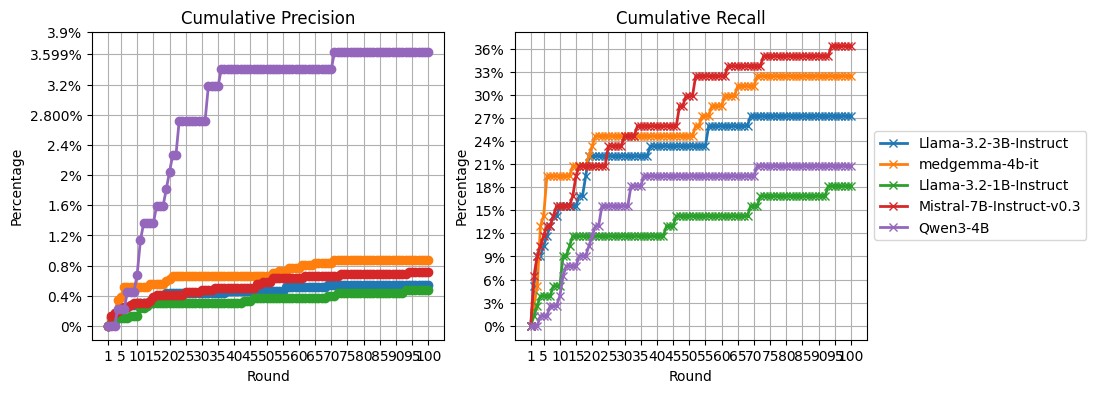

In [24]:
_, axs = plt.subplots(1, 2, figsize=(10, 4))

for system in result.keys():
    axs[0].plot(xRound, result[system]["precision"], marker='o', color=colors[systems.index(system)], linewidth=2, label=systemsName[systems.index(system)])
    axs[1].plot(xRound, result[system]["recall"], marker='x', color=colors[systems.index(system)], linewidth=2, label=systemsName[systems.index(system)])

axs[0].set_xlabel("Round")
axs[1].set_xlabel("Round")

axs[0].set_ylabel("Percentage")
axs[1].set_ylabel("Percentage")

axs[0].grid(True)
axs[1].grid(True)

yticks0 = splitEqualParts(0, maxprecision, 10, 3)
yticks1 = splitEqualParts(0, maxrecall, 10, 2)

axs[0].set_yticks(yticks0)
axs[1].set_yticks(yticks1)

yticks0 = splitEqualPartsLabels(0, maxprecision, 10, 3, "", "%", 100)
yticks1 = splitEqualPartsLabels(0, maxrecall, 10, 2, "", "%", 100)

axs[0].set_yticklabels(yticks0)
axs[1].set_yticklabels(yticks1)

axs[0].set_xticks(xRoundTickList)
axs[1].set_xticks(xRoundTickList)

axs[0].set_title("Cumulative Precision")
axs[1].set_title("Cumulative Recall")

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [25]:
generatedTimes = 35

In [26]:
element = max(set(generated.loc[generated[systemColumn] == systems[1], contentColumn].tolist()), key=generated.loc[generated[systemColumn] == systems[1], contentColumn].tolist().count)
print(element)
print(len(generated[(generated[contentColumn] == element) & (generated[systemColumn] == systems[1])].index))

thumb hypoplasia
81


In [35]:
maxprecision = 0
maxrecall = 0
maxAppearance = 0
maxf1 = 0
maxCoverage = 0

result = {}

for index, system in enumerate(systems):

    maxAppearanceSystem = getHighestAppearance(generated, system)

    if maxAppearanceSystem > maxAppearance:
        maxAppearance = maxAppearanceSystem

    coverage  = []
    precision = []
    recall    = []
    f1        = []
    appearances = []

    for appearance in range(1, maxAppearanceSystem + 1):
        generatedTermsCount = 0

        cover = 0
        for hpoID in testIDs:
            ge = set(getAppearanceSystemHPOData(generated, system, hpoID, appearance))
            go = set(goldData.loc[goldData[hpoidColumn] == hpoID, contentColumn].tolist())

            generatedTermsCount = generatedTermsCount + len(ge)
            
            intersect = list(ge.intersection(go))

            cover = cover + len(intersect)
        if generatedTermsCount > 0:
            precision.append(cover / generatedTermsCount)
            recall.append(cover / len(goldData.index))
            if precision[len(precision) - 1] > 0 and recall[len(recall) - 1] > 0:
                f1.append((2 * precision[len(precision) - 1] * recall[len(recall) - 1]) / (precision[len(precision) - 1] + recall[len(recall) - 1]))
            else:
                f1.append(0)
            coverage.append(cover)
            appearances.append(appearance)

    if (maxrecall < max(recall)):
        maxrecall = max(recall)
    if (maxprecision) < max(precision):
        maxprecision = max(precision)
    if maxCoverage < max(coverage):
        maxCoverage = max(coverage)
    if maxf1 < max(f1):
        maxf1 = max(f1)

    result[system] = {
        "coverage" : coverage,
        "precision" : precision,
        "recall" : recall,
        "f1" : f1, 
        "appearances" : appearances
    }

maxrecall = math.ceil(maxrecall * 100) / 100
maxprecision = math.ceil(maxprecision * 100) / 100

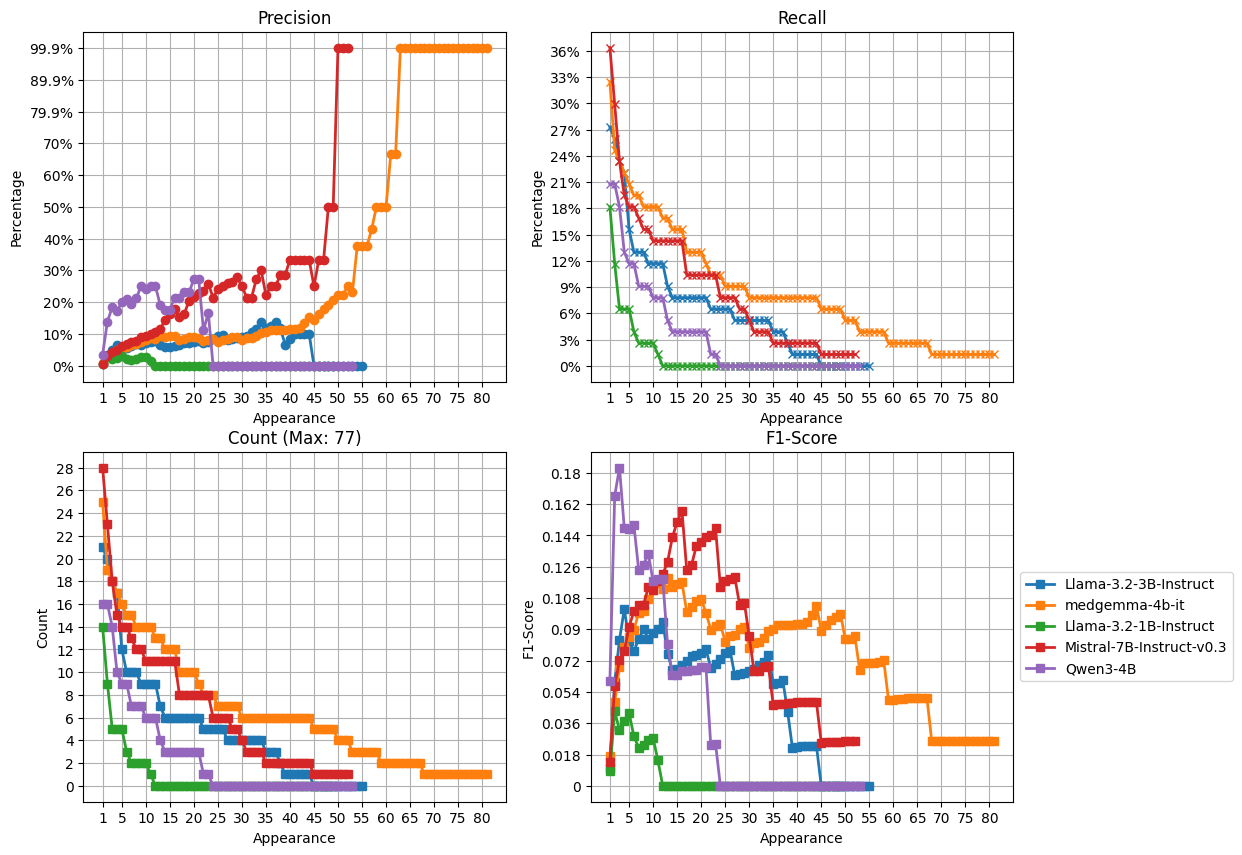

In [45]:
_, axs = plt.subplots(2, 2, figsize=(12, 10))
xAppearanceTickList = [1] + list(np.arange(xRoundTicks, maxAppearance + 1, xRoundTicks))

for system in result.keys():
    axs[0][0].plot(result[system]["appearances"], result[system]["precision"], marker='o', color=colors[systems.index(system)], linewidth=2, label=systemsName[systems.index(system)])
    axs[0][1].plot(result[system]["appearances"], result[system]["recall"], marker='x', color=colors[systems.index(system)], linewidth=2, label=systemsName[systems.index(system)])
    axs[1][0].plot(result[system]["appearances"], result[system]["coverage"], marker='s', color=colors[systems.index(system)], linewidth=2, label=systemsName[systems.index(system)])
    axs[1][1].plot(result[system]["appearances"], result[system]["f1"], marker='s', color=colors[systems.index(system)], linewidth=2, label=systemsName[systems.index(system)])

axs[0][0].set_xlabel("Appearance")
axs[0][1].set_xlabel("Appearance")
axs[1][0].set_xlabel("Appearance")
axs[1][1].set_xlabel("Appearance")

axs[0][0].set_ylabel("Percentage")
axs[0][1].set_ylabel("Percentage")
axs[1][0].set_ylabel("Count")
axs[1][1].set_ylabel("F1-Score")

axs[0][0].grid(True)
axs[0][1].grid(True)
axs[1][0].grid(True)
axs[1][1].grid(True)

yticks0 = splitEqualParts(0, maxprecision, 10, 3)
yticks1 = splitEqualParts(0, maxrecall, 10, 2)
yticks2 = splitEqualParts(0, maxCoverage + 1, 10, 0)
yticks3 = splitEqualParts(0, maxf1, 10, 3)

axs[0][0].set_yticks(yticks0)
axs[0][1].set_yticks(yticks1)
axs[1][0].set_yticks(yticks2)
axs[1][1].set_yticks(yticks3)

yticks0 = splitEqualPartsLabels(0, maxprecision, 10, 3, "", "%", 100)
yticks1 = splitEqualPartsLabels(0, maxrecall, 10, 2, "", "%", 100)
yticks2 = splitEqualPartsLabels(0, maxCoverage + 1, 10, 0, "", "", 1)
yticks3 = splitEqualPartsLabels(0, maxf1, 10, 3, "", "", 1)

axs[0][0].set_yticklabels(yticks0)
axs[0][1].set_yticklabels(yticks1)
axs[1][0].set_yticklabels(yticks2)
axs[1][1].set_yticklabels(yticks3)

axs[0][0].set_xticks(xAppearanceTickList)
axs[0][1].set_xticks(xAppearanceTickList)
axs[1][0].set_xticks(xAppearanceTickList)
axs[1][1].set_xticks(xAppearanceTickList)

axs[0][0].set_title("Precision")
axs[0][1].set_title("Recall")
axs[1][0].set_title(f"Count (Max: {len(goldData.index)})")
axs[1][1].set_title("F1-Score")

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()